## **Appendix 2 - Spatially-Dependent Reliable Shortest Path Problem - Project**

**Course:** AER1516 - Motion Planning for Robotics

**Due:** 22 April 2022

**Team:** Vishal Kanna Annand, Andrew Constantinescu, Sugumar Prabhakaran

### **Introduction**

This code here is to implent a mixed integer program (MIP) or a mixed integer linear program (MILP) to solve the spatially dependent reliable shortest path problem.  Please see Section 4 of our paper for details on the implementation.

In [1]:
# import necessary modules
import numpy as np 
import matplotlib.pyplot as plt
import networkx as nx
from scipy.stats import norm
from math import sqrt

# install gurobi industrial MIP solver
!pip install gurobipy
import gurobipy as gp

# use academic license
# ****INPUT YOUR OWN ACADEMIC LICENSE grbgetkey****

     |████████████████████████████████| 11.5 MB 3.7 MB/s 
Restricted license - for non-production use only - expires 2023-10-25


### **Mathematical Formulation**

* $N$: set of nodes, with $N = \{1, 2, ..., n\}$
* $A$: set of arcs, with $A = \{a_{ij},...\}$
* $a_{ij}$: link from node $i$ to node $j$
* $T_{ij} = (t_{ij}, \sigma_{ij})$:  the normal distribution (mean, std deviation) of travel time for link $a_{ij}$
* $

**Decision Variable**
* $x_{ij}$: binary decision variable signifying link-path incidence - i.e. if link is on path = 1



In [2]:
# PARAMETERS
n = 5           # number of nodes
r = 1           # start node
s = 5           # finish node
alpha = 0.5     # user defined risk tolerance threshold
z = norm.ppf(alpha)

N = [i for i in range(1, n+1)]                      # Set of nodes
A = [(1,2), (1,3), (1,4), (2,3), (3,5), (4,5)]      # Set of arcs
A_w = [(1,2, 2), (1,3, 3), (1,4, 4), (2,3, 2), (3,5, 4), (4,5, 4)] # incl wts
t_ij = {(i,j):k for (i,j,k) in A_w}                 # dict of mean time for arc
indexes = {(j,k):i for i, (j,k) in enumerate(A)}

cov_matrix = np.array([[ 2.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                       [-1.0, 1.0, 0.0, 0.0, 0.0, 0.0],
                       [-1.0,-0.5, 1.0, 0.0, 0.0, 0.0],
                       [ 2.0,-1.0,-0.3, 2.0, 0.0, 0.0],
                       [ 0.3, 1.5,-0.4, 2.0, 6.0, 0.0],
                       [-0.2,-0.6, 0.5,-0.4,-1.5, 1.0]])

print(N)
print(t_ij)
print(cov_matrix)
print(indexes)

[1, 2, 3, 4, 5]
{(1, 2): 2, (1, 3): 3, (1, 4): 4, (2, 3): 2, (3, 5): 4, (4, 5): 4}
[[ 2.   0.   0.   0.   0.   0. ]
 [-1.   1.   0.   0.   0.   0. ]
 [-1.  -0.5  1.   0.   0.   0. ]
 [ 2.  -1.  -0.3  2.   0.   0. ]
 [ 0.3  1.5 -0.4  2.   6.   0. ]
 [-0.2 -0.6  0.5 -0.4 -1.5  1. ]]
{(1, 2): 0, (1, 3): 1, (1, 4): 2, (2, 3): 3, (3, 5): 4, (4, 5): 5}


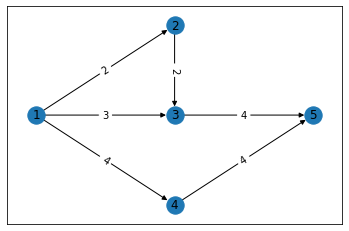

In [3]:
# VISUALIZE DIRECTED GRAPH
positions = {1:[1,3], 2:[3,4], 3:[3,3], 4:[3,2], 5:[5,3]}

# create graph object and add nodes and edges with weights
G = nx.DiGraph()                
G.add_nodes_from(N)
G.add_weighted_edges_from(A_w)

# draw network
nx.draw_networkx(G, positions, with_labels=True)
nx.draw_networkx_edge_labels(G, pos=positions, edge_labels=t_ij)
plt.show()

In [4]:
def sigma_path(path, indexes, cov_matrix, k=1):
    lam = len(path)
    sigma_m = 0     # variance portion
    cov_m = 0       # covariance portion

    # calculate variance portion
    for arc in path:
        sigma_m = sigma_m + cov_matrix[indexes[arc],indexes[arc]]

    # calculate covariance portion
    for n in range(1, k+1):
        for m in range(1, lam-n+1):
            cov_m = cov_m + 2*cov_matrix[indexes[path[m+n-1]], indexes[path[m-1]]]

    return sqrt(sigma_m + cov_m)

def t_path(path, indexes, t_ij):
    t = 0           # initialize mean

    # sum mean for all arcs in path
    for arc in path:
        t = t + t_ij[arc]

    return t

def inv_cdf(t_path, sigma_path, alpha):
    z = norm.ppf(alpha)
    return t_path + z*sigma_path


In [5]:
def idx(arc):
    return indexes[arc]

In [7]:
# INITIALIZE GUROBI MIP MODEL
model = gp.Model("reliable_shortest_path")
model.setParam('TimeLimit', 60) # seconds

Set parameter TimeLimit to value 60


In [31]:
# DECISION VARIABLES

# equation (8) - link-path decision variable is binary
x = model.addVars(A, vtype=gp.GRB.BINARY)
sqrt_covar = model.addVar(name='sqrt_covar')
x2 = {}

covar_arcs = [(a,b) for a in A for b in A if a != b]
covar_arcs_dict = {(a,b):i for i, (a,b) in enumerate(covar_arcs)}
print(covar_arcs_dict)
for i in range(len(covar_arcs_dict)):
        x2[i] = model.addVar(vtype=gp.GRB.BINARY)
print(x)
print(x2)

{((1, 2), (1, 3)): 0, ((1, 2), (1, 4)): 1, ((1, 2), (2, 3)): 2, ((1, 2), (3, 5)): 3, ((1, 2), (4, 5)): 4, ((1, 3), (1, 2)): 5, ((1, 3), (1, 4)): 6, ((1, 3), (2, 3)): 7, ((1, 3), (3, 5)): 8, ((1, 3), (4, 5)): 9, ((1, 4), (1, 2)): 10, ((1, 4), (1, 3)): 11, ((1, 4), (2, 3)): 12, ((1, 4), (3, 5)): 13, ((1, 4), (4, 5)): 14, ((2, 3), (1, 2)): 15, ((2, 3), (1, 3)): 16, ((2, 3), (1, 4)): 17, ((2, 3), (3, 5)): 18, ((2, 3), (4, 5)): 19, ((3, 5), (1, 2)): 20, ((3, 5), (1, 3)): 21, ((3, 5), (1, 4)): 22, ((3, 5), (2, 3)): 23, ((3, 5), (4, 5)): 24, ((4, 5), (1, 2)): 25, ((4, 5), (1, 3)): 26, ((4, 5), (1, 4)): 27, ((4, 5), (2, 3)): 28, ((4, 5), (3, 5)): 29}
{(1, 2): <gurobi.Var *Awaiting Model Update*>, (1, 3): <gurobi.Var *Awaiting Model Update*>, (1, 4): <gurobi.Var *Awaiting Model Update*>, (2, 3): <gurobi.Var *Awaiting Model Update*>, (3, 5): <gurobi.Var *Awaiting Model Update*>, (4, 5): <gurobi.Var *Awaiting Model Update*>}
{0: <gurobi.Var *Awaiting Model Update*>, 1: <gurobi.Var *Awaiting Model

In [36]:
for a in A:
    for b in A:
        if a!=b:
            model.addConstr(x2[covar_arcs_dict[(a,b)]]==x[a]*x[b])

In [9]:
# CONSTRAINTS

# constraint (7) - ensures reliable shortest path is feasible
model.addConstrs(gp.quicksum(x[i,j] for j in G.successors(i))-
                 gp.quicksum(x[k,i] for k in G.predecessors(i)) == 1 
                 for i in N if i == r)
model.addConstrs(gp.quicksum(x[i,j] for j in G.successors(i))-
                 gp.quicksum(x[k,i] for k in G.predecessors(i)) == 0 
                 for i in N if (i != r and i != s))
model.addConstrs(gp.quicksum(x[i,j] for j in G.successors(i))-
                 gp.quicksum(x[k,i] for k in G.predecessors(i)) == -1 
                 for i in N if i == s)

{5: <gurobi.Constr *Awaiting Model Update*>}

In [39]:
path_mean = gp.quicksum(t_ij[a]*x[a] for a in A)
var = gp.quicksum(cov_matrix[idx(a),idx(a)]*x[a] for a in A)
covar = gp.quicksum(cov_matrix[idx(a), idx(b)]*x2[covar_arcs_dict[(a,b)]] 
                                                  for a in A for b in A if a !=b)
path_var = var + 2*covar

In [40]:
model.modelSense = gp.GRB.MINIMIZE

model.setObjective(path_mean*path_mean + 
                   z*z*path_var*path_var + 
                   path_mean*z*path_var)

In [42]:
model.optimize()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads


GurobiError: ignored

In [ ]:
for a in A:
    if x[a].x != 0:
        print(a)
print(sqrt(model.getObjective().getValue()))